In [1]:
import time
import sys
import numpy as np

In [2]:
sys.path.append('/home/chaofan/powerknowledge/data')
from read_PLAID_data import read_processed_data

start_reading_time = time.time()
feature_select = [
    'i_mean', 'i_wave_factor', 'i_pp_rms', 'i_thd', 'pure_thd', 'P', 'Q',
    'P_F', 'i_hp1', 'z_hp1', 'i_hm2', 'z_hm2', 'i_hp2', 'z_hp2', 'i_hm3',
    'z_hm3', 'i_hp3', 'z_hp3', 'i_hm4', 'z_hm4', 'i_hp4', 'z_hp4', 'i_hm5',
    'z_hm5', 'i_hp5', 'z_hp5', 'i_hm6', 'z_hm6', 'i_hp6', 'z_hp6', 'i_hm7',
    'z_hm7', 'i_hp7', 'z_hp7'
]
selected_label = [
    'Air Conditioner', 'Blender', 'Coffee maker', 'Fan', 'Fridge', 'Hair Iron',
    'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Microwave',
    'Soldering Iron', 'Vacuum', 'Washing Machine', 'Water kettle'
]
# selected_label = ['Air Conditioner']
x_mh_train, y_mh_train, mh_index_train = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=20,
    feature_select=feature_select,
    source='submetered_process2.1/training')
y_mh_train = y_mh_train.reshape(-1, 1)

x_mh_validation, y_mh_validation, mh_index_validation = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_process2.1/validation')
y_mh_validation = y_mh_validation.reshape(-1, 1)
x_mh_trainval = np.concatenate((x_mh_train, x_mh_validation), axis=0)
y_mh_trainval = np.concatenate((y_mh_train, y_mh_validation), axis=0)

x_mh_test, y_mh_test, mh_index_test = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_process2.1/testing')
print('finished loading data, cost %.3fs' % (time.time() - start_reading_time))

finished loading data, cost 14.687s


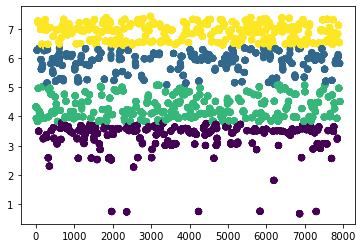

In [43]:
# test
km=KMeans(n_clusters=4, random_state=9)
x=np.log(x_mh_train[:,5]).reshape(-1, 1)
y_pred = km.fit_predict(x)
t=range(0,x.shape[0],1)
plt.scatter(t,x, c=y_pred)
plt.show()
label=km.labels_.tolist()
print(Counter(label))

In [3]:
from sklearn.cluster import KMeans

center_record = {}
centers = {}
feature_lens = 30
for f_index in range(feature_lens):
    n_cluster = 4 * (2 * feature_lens - 2 * f_index) - 4
    km = KMeans(n_clusters=n_cluster, random_state=1)
    if f_index in [5, 6]:
        x = np.log(x_mh_train[:, f_index]).reshape(-1, 1)
    x = x_mh_train[:, f_index].reshape(-1, 1)
    y_pred = km.fit_predict(x).reshape(-1, 1)
    y_mh_train = np.concatenate((y_mh_train, y_pred), axis=1)
    centers[f_index] = [i for item in km.cluster_centers_ for i in item]
    center_record[f_index] = np.argsort(centers[f_index])
y_label = y_mh_train[:, 0]
y_cluster = y_mh_train[:, 1:]

NameError: name 'KMeans' is not defined

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.ticker import MultipleLocator

def calc_pos(total_features_num, feature_index, sort_index):
    edge_len = round(2 * (total_features_num - feature_index))
    if sort_index < 0:
        return None, None
    elif sort_index < 0.5 * edge_len:
        return round(0.5 * edge_len - 1), round(sort_index)
    elif sort_index < 1.5 * edge_len - 1:
        return round(edge_len - 2 - sort_index), round(0.5 * edge_len - 1)
    elif sort_index < 2.5 * edge_len - 2:
        return round(-0.5 * edge_len), round(2 * edge_len - 3 - sort_index)
    elif sort_index < 3.5 * edge_len - 3:
        return round(sort_index - 3 * edge_len + 3), round(-0.5 * edge_len)
    elif sort_index < 4 * edge_len - 4:
        return round(0.5 * edge_len - 1), round(sort_index - 4 * edge_len + 4)


def calc_edge(Node_list):
    edge_list = []
    for node_A in Node_list:
        for node_B in Node_list:
            if node_B == node_A:
                continue
            edge_list.append((node_A, node_B))
    return edge_list


def count_edge(edge_count_dict, edge_list):
    for edge in edge_list:
        if edge not in edge_count_dict.keys():
            edge_count_dict[edge] = 1
        else:
            edge_count_dict[edge] += 1
    return edge_count_dict


def count_node(node_count_dict, node_list):
    for node in node_list:
        if node not in node_count_dict.keys():
            node_count_dict[node] = 1
        else:
            node_count_dict[node] += 1
    return node_count_dict


each_file_len = 10
value_dict = {}
for i, yi_cluster in enumerate(y_cluster):
    if i < 100:
        continue
    if i % each_file_len == 0:
        edge_counts = {}
        node_counts = {}
        feature_len = len(yi_cluster)
        Graph_i = nx.Graph(application=y_label[i])
    nodes_temp = []

    for j, cluster_j in enumerate(yi_cluster):
        cluster_j = int(cluster_j)
        cluster_index = np.argwhere(center_record[j] == cluster_j)
        cluster_index = cluster_index[0][0]
        x, y = calc_pos(feature_len, j, cluster_index)
        # pos.append([x, y])
        # Graph_i.add_node('%02d,%02d' % (x, y), value=centers[j][cluster_j])
        # nodes.append('%02d,%02d' % (x, y))
        nodes_temp.append('%02d,%02d' % (x, y))
        value_dict['%02d,%02d' % (x, y)] = centers[j][cluster_j]

    # calc edge
    edge_list = calc_edge(nodes_temp)
    edge_counts = count_edge(edge_counts, edge_list)
    # calc node
    node_counts = count_node(node_counts, nodes_temp)

    # draw nodes
    if i % each_file_len == each_file_len - 1:
        edge_select = []
        node_select = []
        pos = []
        edge_threshold = 8
        node_threshold = 8

        for k, v in edge_counts.items():
            if v >= edge_threshold:
                edge_select.append(k)
        Graph_i.add_edges_from(edge_select)

        for k, v in node_counts.items():
            if v >= node_threshold:
                node_select.append(k)
                b = k.split(',')
                pos.append([int(b[0]), int(b[1])])
                Graph_i.add_node(k, value=value_dict[k])

        figure1, ax1 = plt.subplots(1, 1)
        npos = dict(zip(node_select, pos))
        nx.draw_networkx_nodes(Graph_i,
                               npos,
                               node_select,
                               node_size=30,
                               label=True)
        nx.draw_networkx_edges(
            Graph_i,
            npos,
            edge_select,
        )
        spacing = 0.5  # This can be your user specified spacing.
        minorLocator = MultipleLocator(spacing)
        # Set minor tick locations.
        ax1.set_xticks(range(-feature_lens, feature_lens+1, 1))
        ax1.set_yticks(range(-feature_lens, feature_lens+1, 1))
        plt.xlim(-feature_lens-0.5, feature_lens+0.5)
        plt.ylim(-feature_lens-0.5, feature_lens+0.5)
        ax1.yaxis.set_minor_locator(minorLocator)
        ax1.xaxis.set_minor_locator(minorLocator)
        # Set grid to use minor tick locations.
        ax1.grid(which='minor')
        plt.show()
        figure1.clear()
        plt.close()

KeyboardInterrupt: 